In [1]:
# Environment setup
const DEPENDENCIES = ["Images", "BenchmarkTools", "TiledIteration", "CairoMakie"];
import Pkg
Pkg.activate(temp=true)
Pkg.add(name="DataFlowTasks", rev="bffb54f9b569cc41856c5002e865d81b042169e3")
foreach(Pkg.add, DEPENDENCIES)

  Activating new project at `/tmp/jl_oL20vF`
   Resolving package versions...
    Updating `/tmp/jl_oL20vF/Project.toml`
  [d1549cb6] + DataFlowTasks v0.2.0 `https://github.com/maltezfaria/DataFlowTasks.jl.git#bffb54f`
    Updating `/tmp/jl_oL20vF/Manifest.toml`
  [34da2185] + Compat v4.15.0
  [d1549cb6] + DataFlowTasks v0.2.0 `https://github.com/maltezfaria/DataFlowTasks.jl.git#bffb54f`
  [bac558e1] + OrderedCollections v1.6.3
  [6c6a2e73] + Scratch v1.2.1
  [0dad84c5] + ArgTools v1.1.1
  [56f22d72] + Artifacts
  [2a0f44e3] + Base64
  [ade2ca70] + Dates
  [f43a241f] + Downloads v1.6.0
  [7b1f6079] + FileWatching
  [b77e0a4c] + InteractiveUtils
  [b27032c2] + LibCURL v0.6.4
  [76f85450] + LibGit2
  [8f399da3] + Libdl
  [37e2e46d] + LinearAlgebra
  [56ddb016] + Logging
  [d6f4376e] + Markdown
  [ca575930] + NetworkOptions v1.2.0
  [44cfe95a] + Pkg v1.10.0
  [de0858da] + Printf
  [3fa0cd96] + REPL
  [9a3f8284] + Random
  [ea8e919c] + SHA v0.7.0
  [9e88b42a] + Serialization
  [6462fe0b] +

# Blur & Roberts image filters


This example illustrate the use of `DataFlowTasks.jl` to parallelize the tiled
application of two kernels used in image processing. The application first
applies a blur filter on each pixel of the image; in a second step, the [Roberts
cross operator](https://en.wikipedia.org/wiki/Roberts_cross) is applied to
detect edges in the image.

Let us first load a test image:

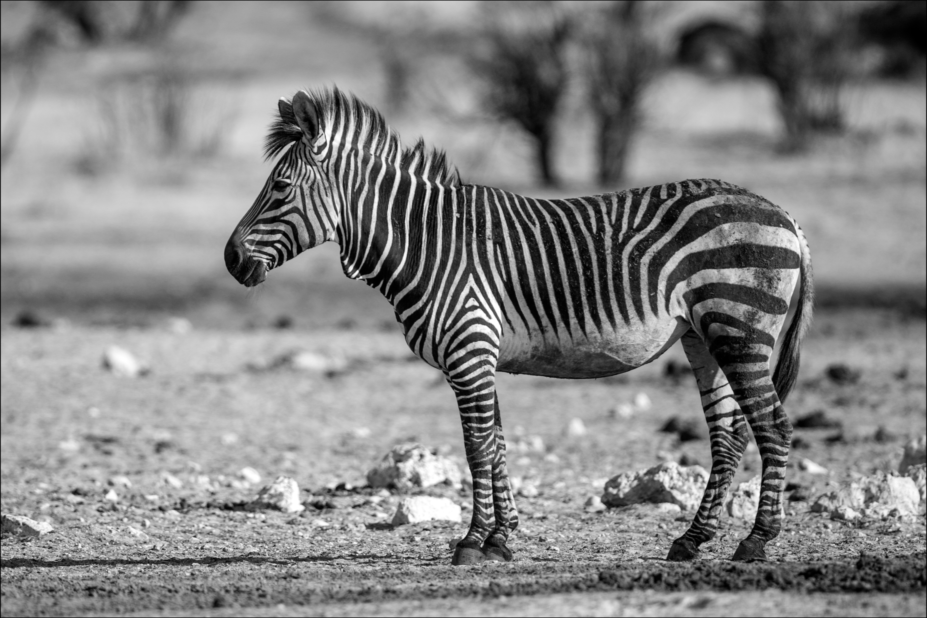

In [2]:
using Images
url = "https://upload.wikimedia.org/wikipedia/commons/c/c3/Equus_zebra_hartmannae_-_Etosha_2015.jpg"
ispath("test-image.jpg") || download(url, "test-image.jpg")
img = Gray.(load("test-image.jpg"))

We start by defining a few helper functions:

- the `contract` and `expand` functions manipulate ranges of indices in order
  to respectively contract or expand them by a few pixels;

- the `img2mat` and `mat2img` convert between a Gray-scale image and a matrix
  of floating-point pixel intensities. The filters will work on this latter
  representation, which may need a renormalization to be converted back to a
  Gray-scale image.

In [3]:
contract(range,n) = range[begin+n:end-n]
expand(range,n)   = range[begin]-n:range[end]-n

function img2mat(img)
    PixelType = eltype(img)
    mat = Float64.(img)
    return (PixelType, mat)
end

function mat2img(PixelType, mat)
    m1, m2 = extrema(mat)
    PixelType.((mat .- m1) ./ (m2-m1))
end

PixelType, mat = img2mat(img);

## Filters implementation

The `blur!` function averages the value of each pixel with the values of all
pixels less than `width` pixels away in manhattan distance. In order to
simplify the implementation, the filter is applied only to pixels that are
sufficiently far from the boundary to have all their neighbors correctly
defined.

Results are written in-place in a pre-allocated `dest` array. Unless otherwise
specified, the filter is applied to the whole image, but can be reduced to a
tile if a smaller `range` argument is provided.

In [4]:
function blur!(dest, src; range=axes(src), width)
    ri, rj = intersect.(range, contract.(axes(src), width))

    weight = 1/(2*width+1)^2
    @inbounds for i in ri, j in rj
        dest[i,j] = 0
        for δi in -width:width, δj in -width:width
            dest[i,j] += src[i+δi, j+δj]
        end
        dest[i,j] *= weight
    end
end

blur! (generic function with 1 method)

In the following, we'll use a filter width of 5 pixels, which produces the
following results on the test image:

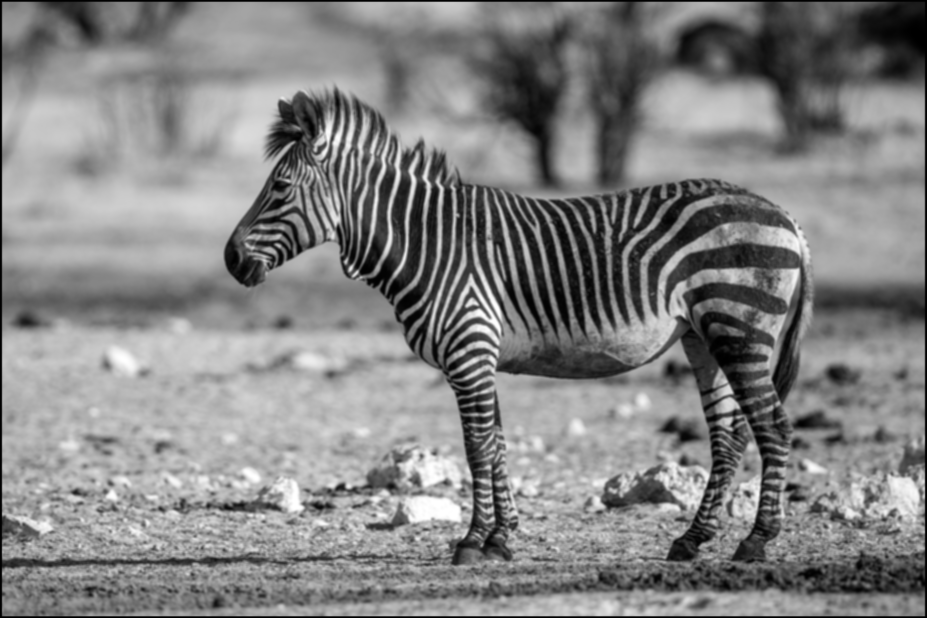

In [5]:
width = 5
blurred = zero(mat)

blur!(blurred, mat; width)

mat2img(PixelType, blurred)

 The `roberts!` function applies the Roberts cross operator to the provided
 image. Like above, it operates by default on all pixels in the image
 (provided they are sufficiently far from the boundaries), but can be
 restricted to work on a tile if the `range` argument is provided.

In [6]:
function roberts!(dest, src; range=axes(src))
    ri, rj = intersect.(range, contract.(axes(src), 1))

    for i in ri, j in rj
        dest[i,j] = (
            + (sqrt(src[i,  j]) - sqrt(src[i+1,j+1]))^2
            + (sqrt(src[i+1,j]) - sqrt(src[i  ,j+1]))^2
        )^(0.25)
    end
end

roberts! (generic function with 1 method)

Applying this edge detection filter on the original image produces the
following results:

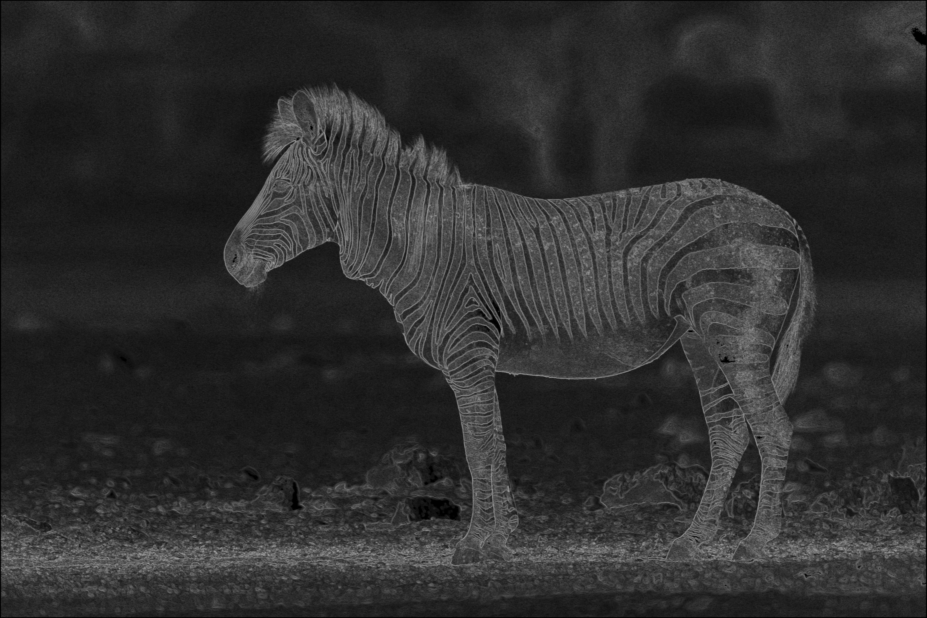

In [7]:
contour = zero(mat)
roberts!(contour, mat)

mat2img(PixelType, contour)

Chaining the blur and roberts filters may make edge detection less noisy:

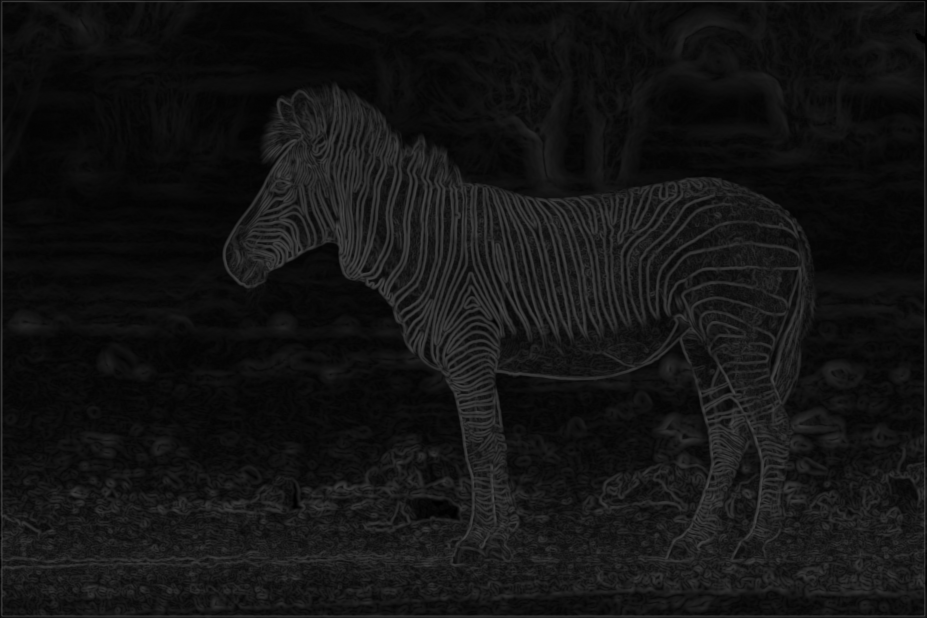

In [8]:
function blur_roberts!(img; width, tmp=zero(img))
    blur!(tmp, img; width)
    roberts!(img, tmp)
end

mat1 = copy(mat)
tmp  = zero(mat)

blur_roberts!(mat1; width, tmp)
mat2img(PixelType, mat1)

The elapsed time in this sequential version will serve as reference to
evaluate the performance of other implementations:

In [9]:
using BenchmarkTools
t_seq = @belapsed blur_roberts!(x, width=$width, tmp=$tmp) setup=(x=copy(mat)) evals=1

2.006497388

## Tiled filter application

The [`TiledIteration.jl`](https://github.com/JuliaArrays/TiledIteration.jl)
package implements various tools allowing to define and iterate over disjoint
tiles of a larger array. We'll use it to apply the filters tile by tile.

The `map_tiled!` higher-order function automates the application of a filter
`fun!` on all pixels of an image `src` decomposed with a tilesize `ts`. This
higher-order function is then used to define tiled versions of the blur and
roberts filters.

In [10]:
using TiledIteration

function map_tiled!(fun!, dest, src, ts)
    for tile in TileIterator(axes(src), (ts, ts))
        fun!(dest, src, tile)
    end
end

blur_tiled!(dest, src, ts; width) = map_tiled!(dest, src, ts) do dest, src, tile
    blur!(dest, src; width, range=tile)
end

roberts_tiled!(dest, src, ts) = map_tiled!(dest, src, ts) do dest, src, tile
    roberts!(dest, src; range=tile)
end

function blur_roberts_tiled!(img, ts; width, tmp=zero(img))
    blur_tiled!(tmp, img, ts; width)
    roberts_tiled!(img, tmp, ts)
end

blur_roberts_tiled! (generic function with 1 method)

Decomposing the original image in tiles of size $512\times 512$, the tiled
application of the filters yields the same result as above:

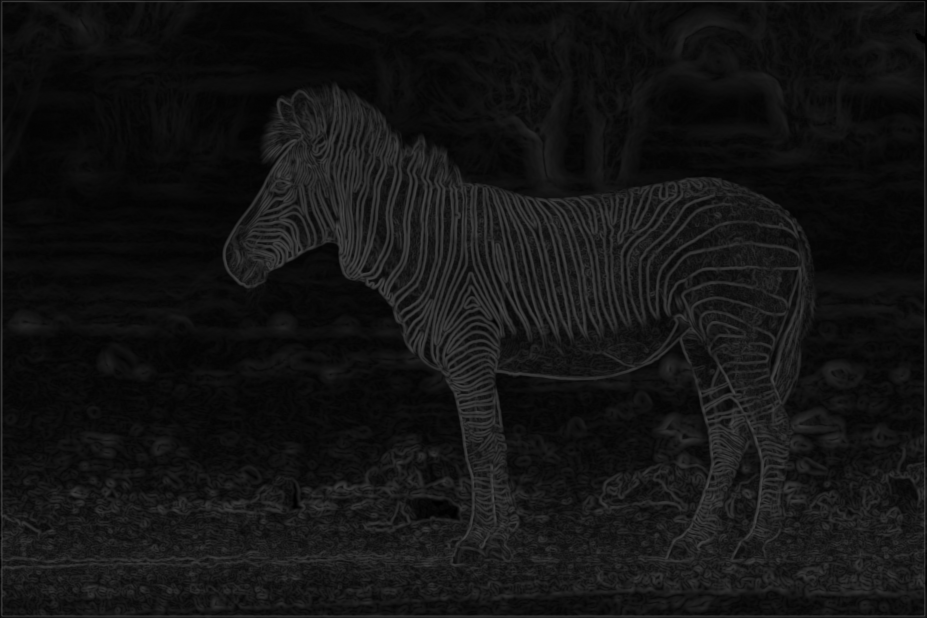

In [11]:
ts = 512

mat1 .= mat
blur_roberts_tiled!(mat1, ts; width, tmp)

mat2img(PixelType, mat1)

Depending on the system, the fact that memory is now accessed in blocks may
(or may not) have a significant impact on the performance, due to cache
effects.

In [12]:
t_tiled = @belapsed blur_roberts_tiled!(x, ts; width=$width, tmp=$tmp) setup=(x=copy(mat)) evals=1

1.911511772

## Parallel filter application

Parallelizing the tiled filter application is relatively straightforward using
`DataFlowTasks.jl`. As usual, it involves specifying which data is accessed by
each task.

In [13]:
using DataFlowTasks

function blur_dft!(dest, src, ts; width)
    map_tiled!(dest, src, ts) do dest, src, tile
        outer = intersect.(expand.(tile, width), axes(src))
        @dspawn begin
            @R view(src, outer...)
            @W view(dest, tile...)
            blur!(dest, src; width, range=tile)
        end label="blur ($tile)"
    end
    @dspawn @R(dest) label="blur (result)"
end

function roberts_dft!(dest, src, ts)
    map_tiled!(dest, src, ts) do dest, src, tile
        outer = intersect.(expand.(tile, 1), axes(src))
        @dspawn begin
            @R view(src, outer...)
            @W view(dest, tile...)
            roberts!(dest, src; range=tile)
        end label="roberts ($tile)"
    end
    @dspawn @R(dest) label="roberts (result)"
end

roberts_dft! (generic function with 1 method)

Note how each filter spawns one task for each tile, and an extra task to get
the results in the end. This allows applying a given filter independently of
the other.

However, the filters remain composable: when applying both filters one after
the other, no implicit synchronization is enforced at the end of the blurring
stage, and the runtime may decide to intersperse blurring and roberts tasks
(as long as the blurring of a tile and all its neighbors is performed before
the application of the roberts filter on this tile).

In [14]:
function blur_roberts_dft!(img, ts; width, tmp=zero(img))
    blur_dft!(tmp, img, ts; width)
    roberts_dft!(img, tmp, ts)
    @dspawn @R(img) label="result"
end

blur_roberts_dft! (generic function with 1 method)

Again this yields the same results on the test image:

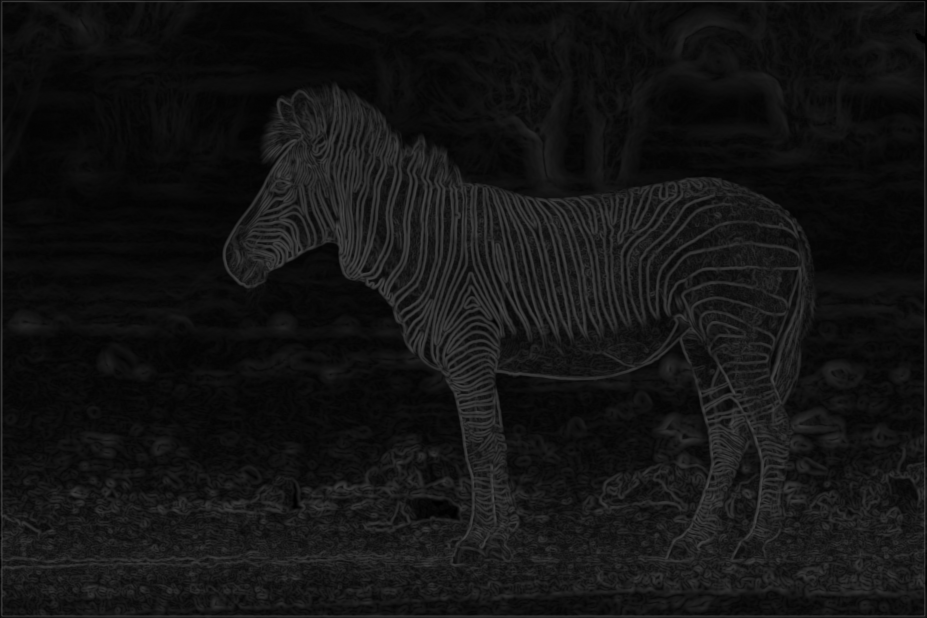

In [15]:
mat1 .= mat;
blur_roberts_dft!(mat1, ts; width, tmp) |> wait

mat2img(PixelType, mat1)

In [16]:
t_dft = @belapsed wait(blur_roberts_dft!(x, ts; width=$width, tmp=$tmp)) setup=(x = copy(mat)) evals=1

0.287647994

## Performance analysis

Status `~/.julia/scratchspaces/d1549cb6-e9f4-42f8-98cc-ffc8d067ff5b/weakdeps-1.10/Project.toml`
⌃ [13f3f980] CairoMakie v0.10.12
⌃ [e9467ef8] GLMakie v0.8.12
  [f526b714] GraphViz v0.2.0
⌅ [ee78f7c6] Makie v0.19.12
Info Packages marked with ⌃ and ⌅ have new versions available. Those with ⌃ may be upgradable, but those with ⌅ are restricted by compatibility constraints from upgrading. To see why use `status --outdated`


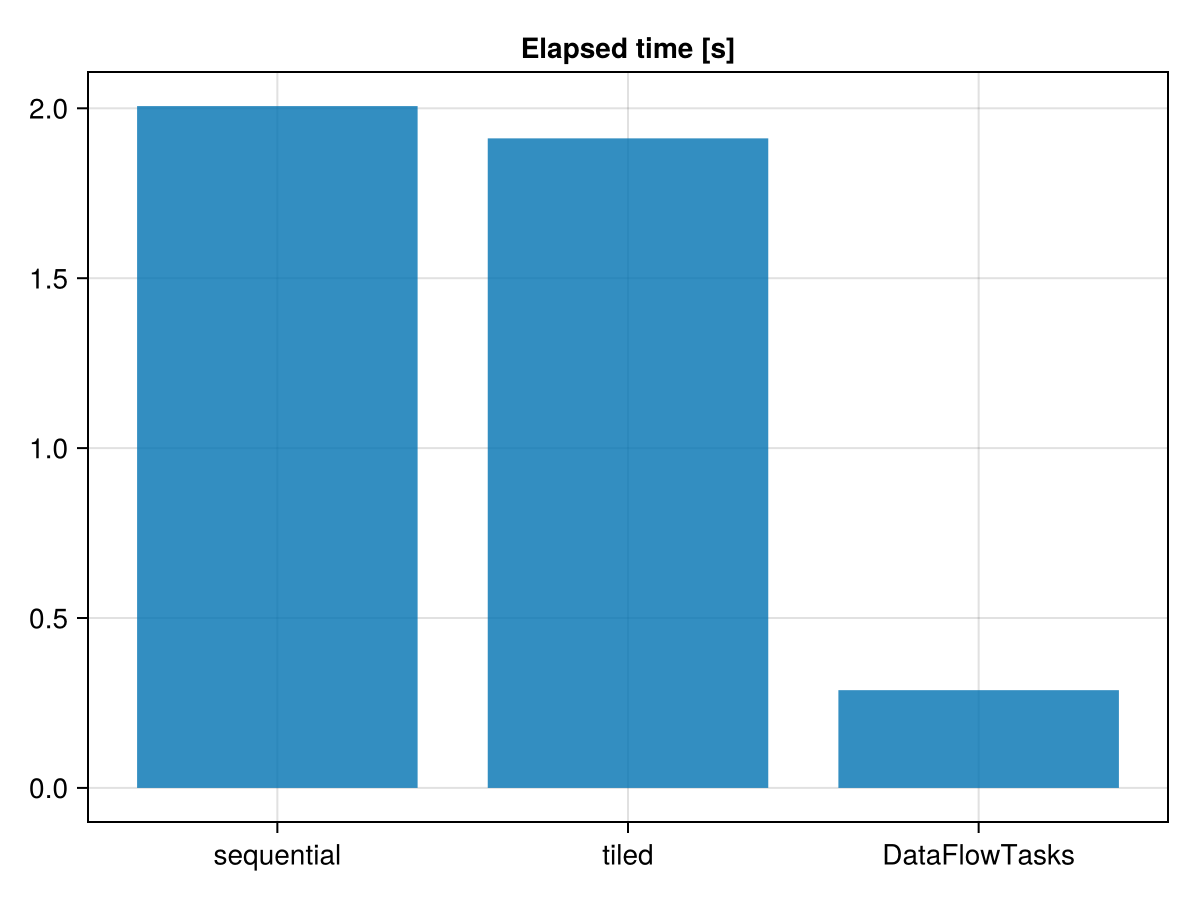

In [17]:
DataFlowTasks.stack_weakdeps_env!()
using CairoMakie

barplot([t_seq, t_tiled, t_dft],
        axis = (; title = "Elapsed time [s]",
                xticks=(1:3, ["sequential", "tiled", "DataFlowTasks"])))

A comparison of the performances of all implementations shows that the
DataFlowTasks-based implementation produces a good speedup:

In [18]:
(;
 nthreads = Threads.nthreads(),
 speedup = t_seq / t_dft)

(nthreads = 8, speedup = 6.975530613295359)

We can gain more insight by collecting profiling data:

In [19]:
GC.gc()
mat1 .= mat;
log_info = DataFlowTasks.@log wait(blur_roberts_dft!(mat1, ts; width, tmp))
DataFlowTasks.describe(log_info)

• Elapsed time           : 0.292
  ├─ Critical Path       : 0.082
  ╰─ No-Wait             : 0.283

• Run time               : 2.338
  ├─ Computing           :   2.263
  │  ╰─ unlabeled        :     2.263
  ├─ Task Insertion      :   0.001
  ╰─ Other (idle)        :   0.074


The parallel trace shows how blur and roberts tasks are interspersed in the time line:

┌ Warning: Found `resolution` in the theme when creating a `Scene`. The `resolution` keyword for `Scene`s and `Figure`s has been deprecated. Use `Figure(; size = ...` or `Scene(; size = ...)` instead, which better reflects that this is a unitless size and not a pixel resolution. The key could also come from `set_theme!` calls or related theming functions.
└ @ Makie ~/.julia/packages/Makie/iRM0c/src/scenes.jl:220
[ Info: Computing    : 2.2631933959999992
[ Info: Inserting    : 0.000557476
[ Info: Other        : 0.07449526490376322


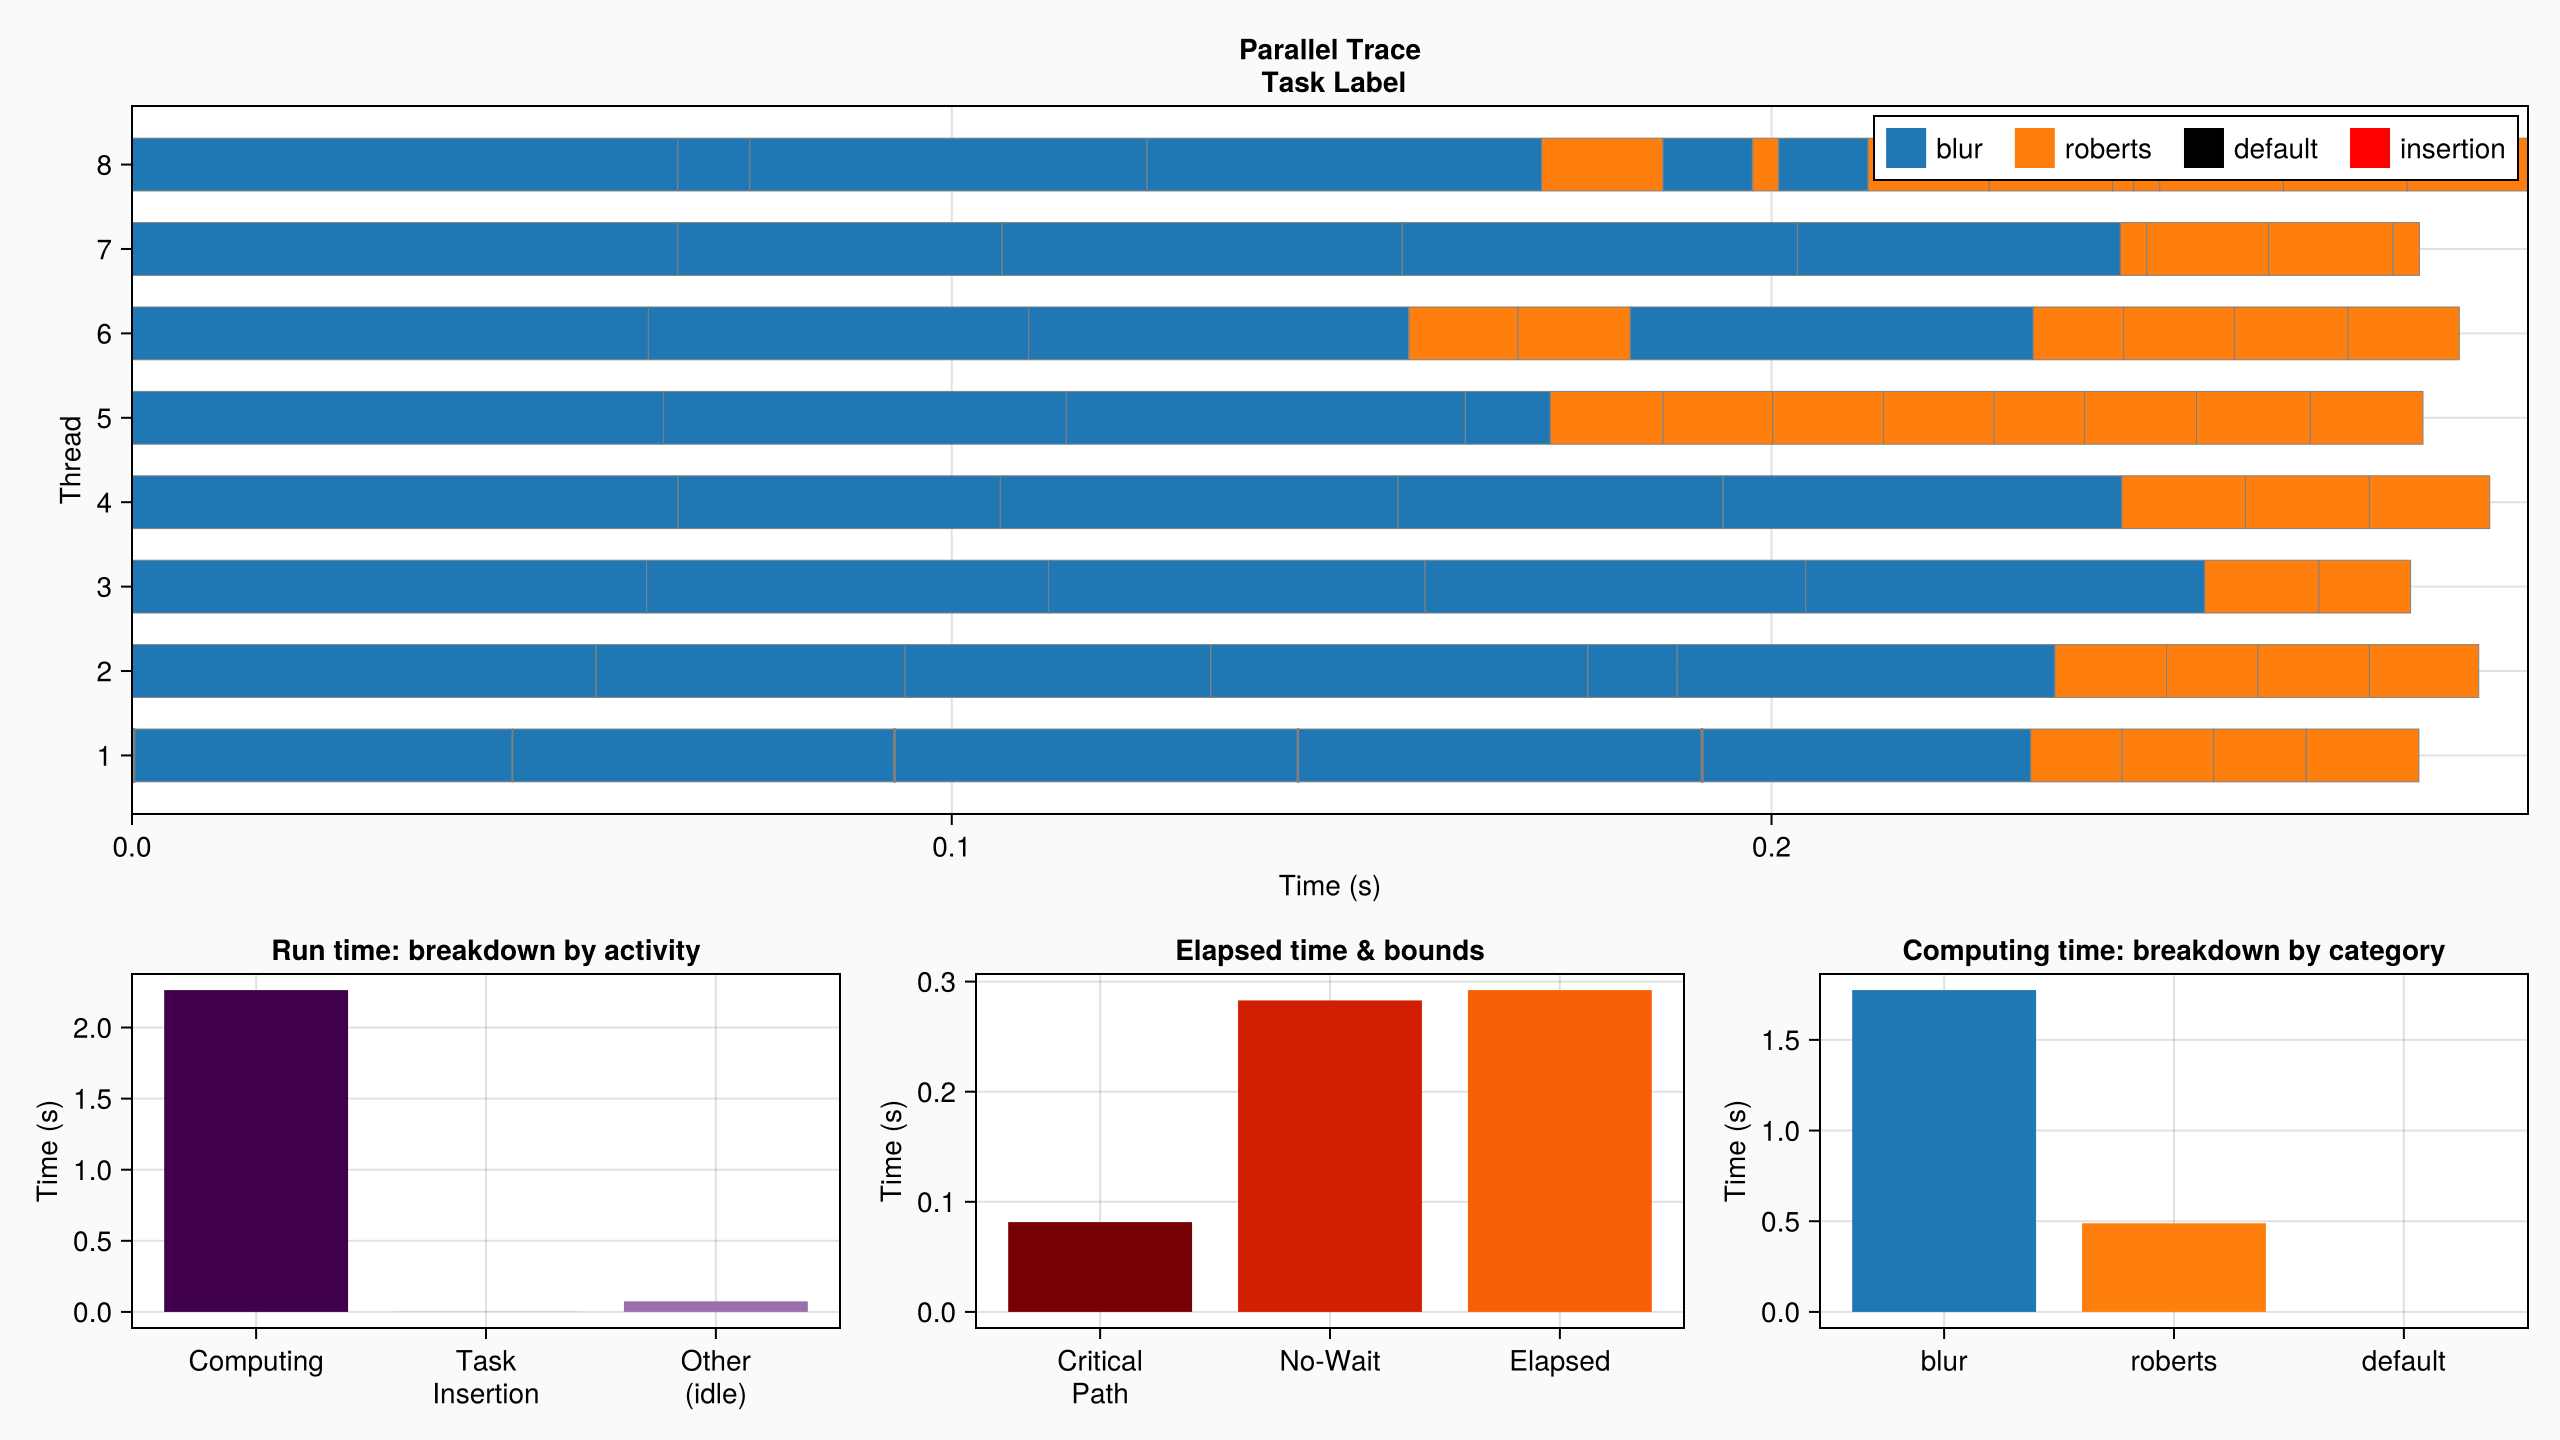

In [20]:
trace = plot(log_info, categories=["blur", "roberts"])

---

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*